## 学習と精度を確認する
- RF、XGBoost、LGBMで学習と精度を確認
- テキストのみで予測するパターンと、テーブルデータとして予測するパターンを追加
- 直近N年の評価をValidationデータ、それ以外を学習データとして利用
- LGBMは交差検証とOOFによる閾値最適化を実施

In [22]:
from importlib import reload

from classification import ml_token_classification_rf
from classification import ml_token_classification_xgb
from classification import ml_token_classification_lgb

from classification import ml_numerical_classification_rf
from classification import ml_numerical_classification_xgb
from classification import ml_numerical_classification_lgb

from classification import cm

from sklearn.model_selection import train_test_split

import numpy as np


In [23]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns

# ====== パラメータ（必要に応じて変更） ======
RANDOM_SEED = 42
N_SPLITS = 5
# 列名
TEXT_COL = "description"          # テキスト列
LABEL_BINARY_COL = "eval_binary"  # 目的変数（0/1）
YEAR_COL = "project_start_year"   # 年度列（数値化可能であること）
THRESHOLD = 100 # 閾値
THRESH_OBJECTIVE = "balanced_accuracy"  # 閾値最適化の指標

# テストに使う直近年数
TEST_LAST_N = 5
# cost_success_flg, duration_success_flg, total_eval
SOURCE_ORDINAL_COL = "total_eval"

In [24]:
import pandas as pd
df_ori = pd.read_csv("../df_check_ml.csv")  # ←必要ならCSV読み込み

df_ori.columns

Index(['Unnamed: 0_x', 'file', 'country', 'eval_year', 'evaluator_group',
       'evaluator', 'project_cost_plan', 'project_cost_act', 'プロジェクト期間開始_計画時',
       'プロジェクト期間終了_計画時', 'プロジェクト期間開始_実績', 'プロジェクト期間終了_実績',
       'project_duration_plan', 'project_duration_act', '妥当性評価', '整合性評価',
       '有効性評価', 'インパクト評価', '効率性評価', '効率性_コスト', '効率性_期間', '持続性評価', '適応・貢献評価',
       '付加価値・創造価値評価', '総合評価', '備考', 'type', '分野', '案件名', '連番', 'region',
       'region_detail', 'alpha2', 'alpha3', 'project_start_year',
       'project_end_year', 'join_flg_x', 'Year', 'external_eval_flg',
       'その他_flg_fix', 'インフラ_flg_fix', 'エネルギー一般_flg_fix', '人材・教育_flg_fix',
       '保健・社会福祉_flg_fix', '公益事業一般_flg_fix', '商業経営_flg_fix', '工業_flg_fix',
       '放送_flg_fix', '林業・森林保全_flg_fix', '水産_flg_fix', '水資源開発_flg_fix',
       '海運_flg_fix', '測量・地図_flg_fix', '災害・食料援助_flg_fix', '災害対策_flg_fix',
       '環境_flg_fix', '畜産_flg_fix', '社会基盤一般_flg_fix', '航空・空港_flg_fix',
       '行政一般_flg_fix', '観光一般_flg_fix', '貿易_flg_fix', '農業一般_flg_fix

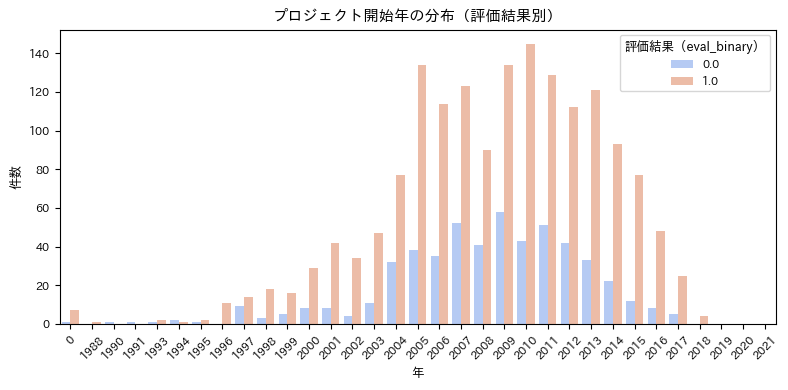

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.countplot(
    data=df_ori,
    x=YEAR_COL,
    hue="eval_binary",
    palette="coolwarm"
)
plt.title("プロジェクト開始年の分布（評価結果別）", fontsize=11)  # タイトル小さく
plt.xlabel("年", fontsize=9)                     # 軸ラベル小さく
plt.ylabel("件数", fontsize=9)
plt.xticks(rotation=45, fontsize=8)                              # x軸目盛りの文字サイズ
plt.yticks(fontsize=8)                                           # y軸目盛りの文字サイズ
plt.legend(title="評価結果（eval_binary）", fontsize=8, title_fontsize=9)
plt.tight_layout()
plt.show()

In [26]:
# 利用するテキストの特徴量を生成
df_ori['sentence'] = df_ori['background']+df_ori['description']

In [27]:
## 評価がないレコードを除外
print(df_ori['eval_binary'].isnull().sum())
df_ori = df_ori.dropna(subset=['eval_binary'])

50


In [28]:
df_ori = df_ori.rename(columns={
  LABEL_BINARY_COL: "label",
})

In [29]:
## textがないレコードを除外
print(df_ori['sentence'].isnull().sum())
df = df_ori.dropna(subset=['sentence'])

8


In [30]:
## train_test分割
train_df = df[df[YEAR_COL] <= (df[YEAR_COL].max() - TEST_LAST_N)]
valid_df = df[df[YEAR_COL] > (df[YEAR_COL].max() - TEST_LAST_N)]

# RandomForest
### 実施内容だけでの予測

Accuracy: 0.8424657534246576
Precision: 0.9209621993127148
Recall: 0.5106382978723404
Macro F1: 0.47792288557213924
Balanced Accuracy: 0.5106382978723404
SHAP values array shape: (2, 292, 8259)


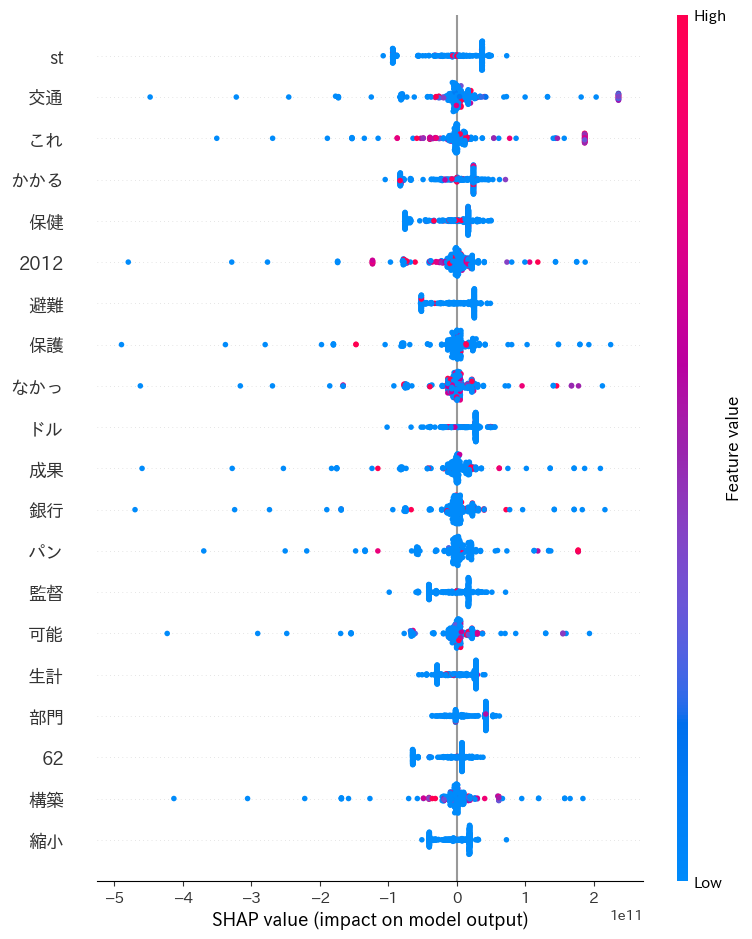

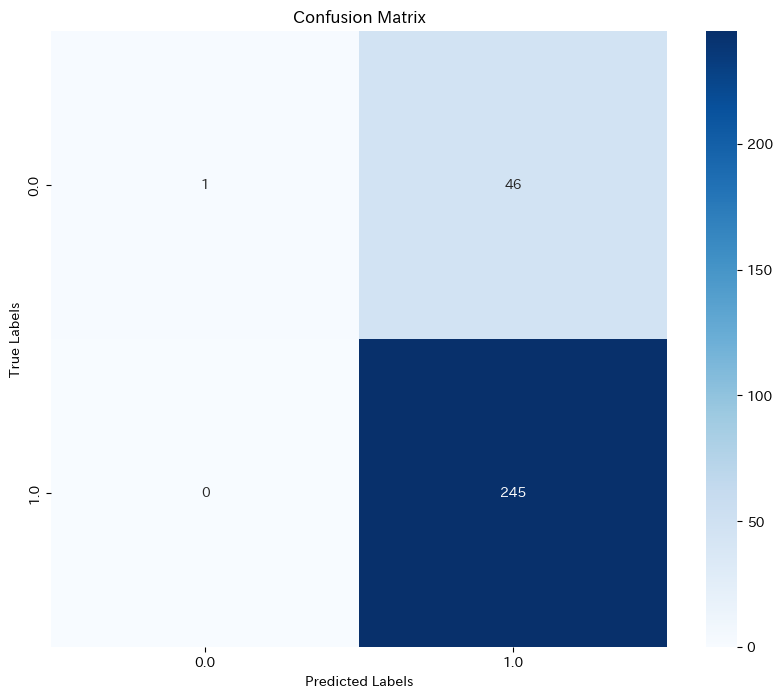

method, class, accuracy, precision, recall
proposed, all, 0.8424657534246576, 0.9209621993127148, 0.5106382978723404
proposed, 0.0, non, 1.0, 0.02127659574468085
proposed, 1.0, non, 0.8419243986254296, 1.0
baseline, all, 0.7298977294051416, 0.5, 0.5
baseline, 0.0, non, 0.16095890410958905, 0.16095890410958905
baseline, 1.0, non, 0.839041095890411, 0.839041095890411


In [31]:

reload(ml_token_classification_rf)

ml_token_classification_rf.train_and_evaluate_model(train_df=train_df, valid_df=valid_df, model_name="cl-tohoku/bert-base-japanese-v3")
cm.vis('results/classification/confusion_matrix_text_rf.csv','results/classification/result_text_rf.csv')


# XGBoost
### 実施内容だけでの予測

[17:16:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



Accuracy: 0.7636986301369864
Precision: 0.49735576923076924
Recall: 0.4980894485453756
Macro F1: 0.494974307557338
Balanced Accuracy: 0.4980894485453756
2


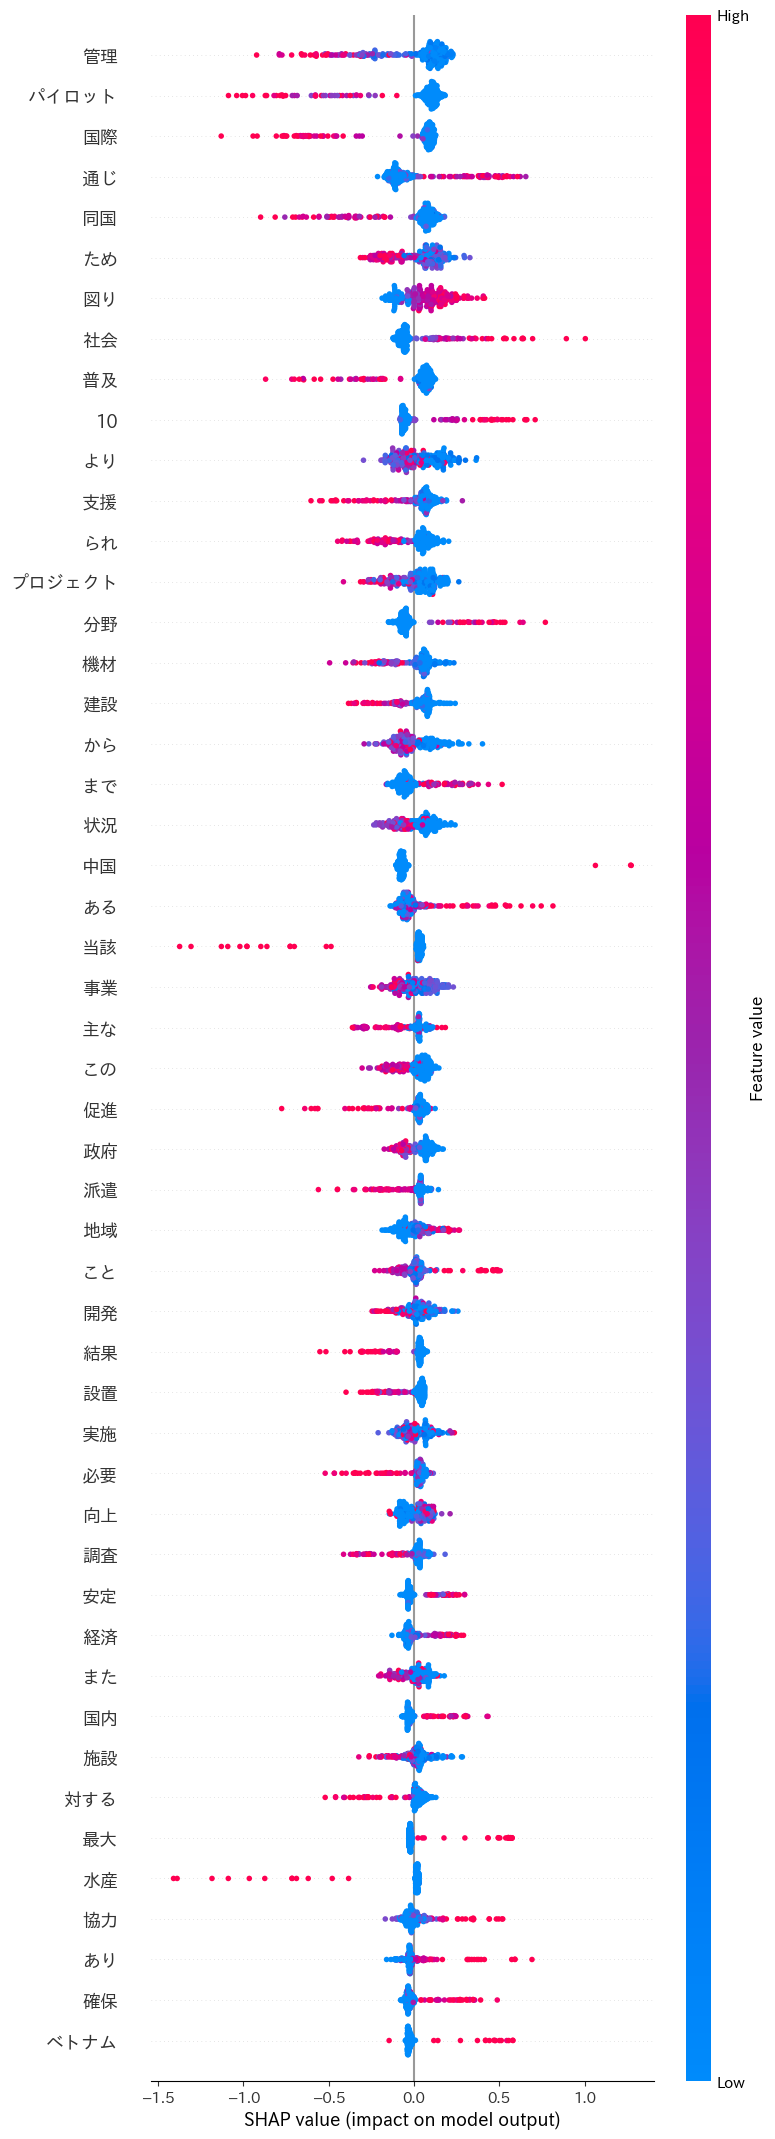

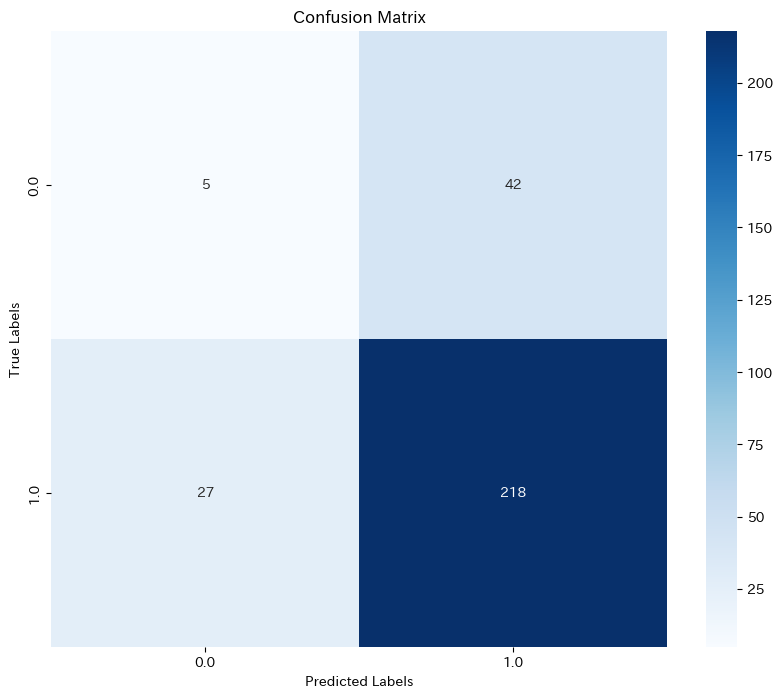

method, class, accuracy, precision, recall
proposed, all, 0.7636986301369864, 0.49735576923076924, 0.4980894485453756
proposed, 0.0, non, 0.15625, 0.10638297872340426
proposed, 1.0, non, 0.8384615384615385, 0.889795918367347
baseline, all, 0.7298977294051416, 0.5, 0.5
baseline, 0.0, non, 0.16095890410958905, 0.16095890410958905
baseline, 1.0, non, 0.839041095890411, 0.839041095890411


In [32]:
reload(ml_token_classification_xgb)
ml_token_classification_xgb.train_and_evaluate_model(train_df=train_df, valid_df=valid_df, model_name="cl-tohoku/bert-base-japanese-v3")
cm.vis('results/classification/confusion_matrix_text_xgb.csv','results/classification/result_text_xgb.csv')


# LighGBM
### 実施内容だけでの予測

[LightGBM] [Info] Number of positive: 1119, number of negative: 382
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54685
[LightGBM] [Info] Number of data points in the train set: 1501, number of used features: 1552
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.745503 -> initscore=1.074770
[LightGBM] [Info] Start training from score 1.074770
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


SHAP values array shape: (2, 292, 7610)


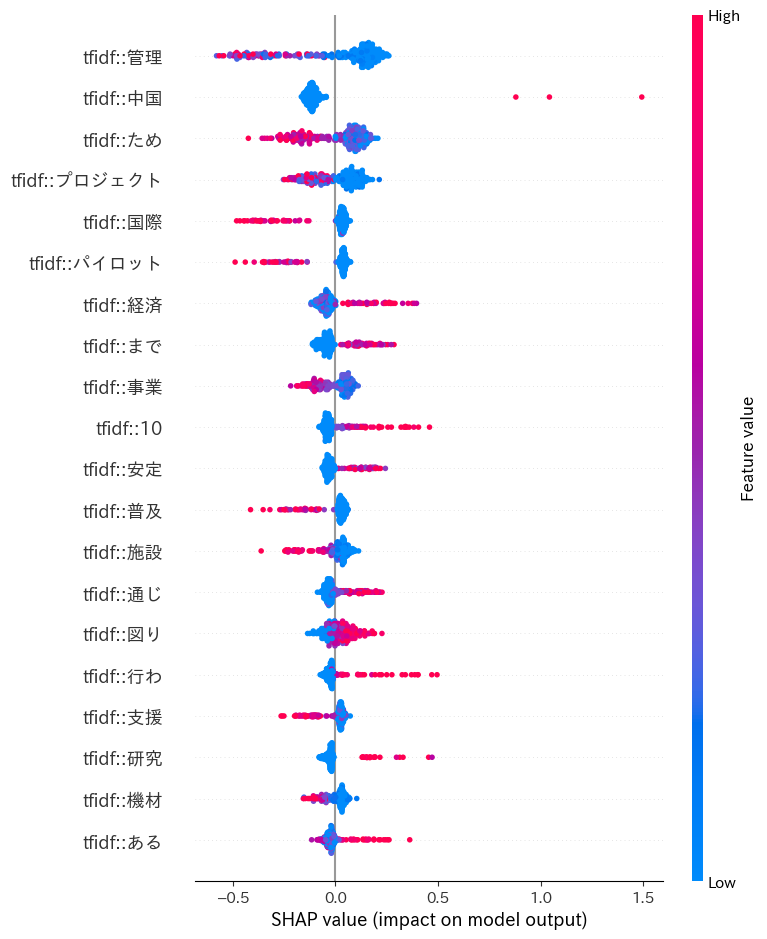

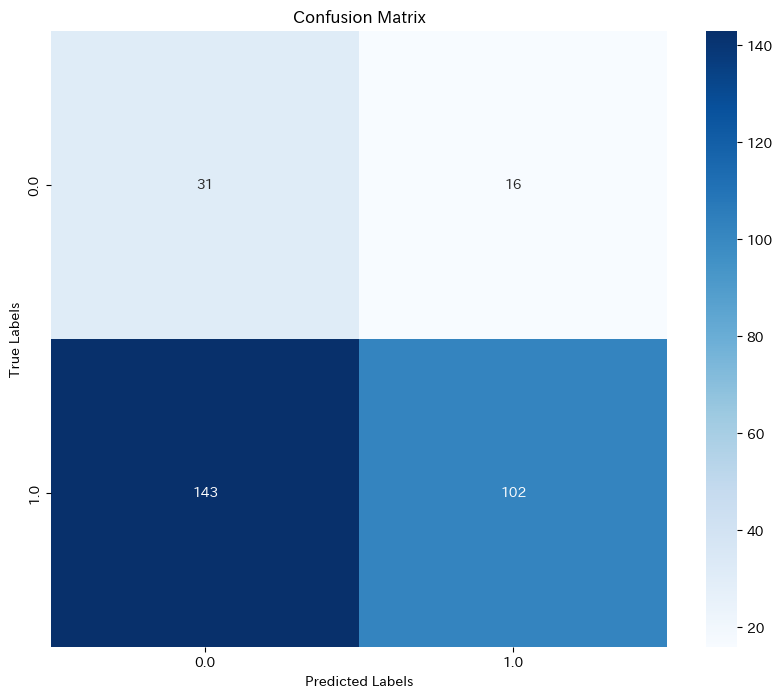

method, class, accuracy, precision, recall
proposed, all, 0.4554794520547945, 0.5212838496006235, 0.5379504993486757
proposed, 0.0, non, 0.1781609195402299, 0.6595744680851063
proposed, 1.0, non, 0.864406779661017, 0.4163265306122449
baseline, all, 0.7298977294051416, 0.5, 0.5
baseline, 0.0, non, 0.16095890410958905, 0.16095890410958905
baseline, 1.0, non, 0.839041095890411, 0.839041095890411


In [33]:
reload(ml_token_classification_lgb)
ml_token_classification_lgb.train_and_evaluate_model(train_df=train_df, valid_df=valid_df, model_name="cl-tohoku/bert-base-japanese-v3")
cm.vis('results/classification/confusion_matrix_text_lgb.csv','results/classification/result_text_lgb.csv')


## テキスト外特徴量の追加

## 特徴量指定

In [34]:
df.columns

Index(['Unnamed: 0_x', 'file', 'country', 'eval_year', 'evaluator_group',
       'evaluator', 'project_cost_plan', 'project_cost_act', 'プロジェクト期間開始_計画時',
       'プロジェクト期間終了_計画時', 'プロジェクト期間開始_実績', 'プロジェクト期間終了_実績',
       'project_duration_plan', 'project_duration_act', '妥当性評価', '整合性評価',
       '有効性評価', 'インパクト評価', '効率性評価', '効率性_コスト', '効率性_期間', '持続性評価', '適応・貢献評価',
       '付加価値・創造価値評価', '総合評価', '備考', 'type', '分野', '案件名', '連番', 'region',
       'region_detail', 'alpha2', 'alpha3', 'project_start_year',
       'project_end_year', 'join_flg_x', 'Year', 'external_eval_flg',
       'その他_flg_fix', 'インフラ_flg_fix', 'エネルギー一般_flg_fix', '人材・教育_flg_fix',
       '保健・社会福祉_flg_fix', '公益事業一般_flg_fix', '商業経営_flg_fix', '工業_flg_fix',
       '放送_flg_fix', '林業・森林保全_flg_fix', '水産_flg_fix', '水資源開発_flg_fix',
       '海運_flg_fix', '測量・地図_flg_fix', '災害・食料援助_flg_fix', '災害対策_flg_fix',
       '環境_flg_fix', '畜産_flg_fix', '社会基盤一般_flg_fix', '航空・空港_flg_fix',
       '行政一般_flg_fix', '観光一般_flg_fix', '貿易_flg_fix', '農業一般_flg_fix

In [35]:
ohe_col = [
    #'project_start_year',
    'country',
    'region_detail',
    'type',
]
df = pd.get_dummies(df_ori, columns=ohe_col)


# 例: 既存ノートのfeaturesを再掲。必要に応じて変更/追加してください。
features = [
    'project_cost_plan', 
    'project_duration_plan', 
    'control_of_corruption', 
    'government_effectiveness', 
    'political_stability', 
    'regulatory_quality', 
    'rule_of_law', 
    'voice_and_accountability', 
    'freedom_house_score', 
    'gdp_growth', 
    'population', 
    'sentence', 
]

# one-hot列
country_columns = [c for c in df.columns if c.startswith('country_')]
type_columns = [c for c in df.columns if c.startswith('type_')]
region_columns = [c for c in df.columns if c.startswith('region_detail_')]
project_start_year_columns = [c for c in df.columns if c.startswith('project_start_year')]
sector_columns = [c for c in df.columns if 'flg_fix' in c]
eva_columns = [c for c in df.columns if c.startswith('evaluator_group_')]

features = features + country_columns + type_columns + region_columns + sector_columns + eva_columns


## RandomForest
- 数値系特徴量の追加

In [36]:
## random forest用にNaN特徴量の行を除外
df_random = df.dropna(subset=features)
rf_feat = features.copy()
rf_feat.remove('sentence')

## train_test分割
train_rf_df = df_random[df_random[YEAR_COL] <= (df_random[YEAR_COL].max() - TEST_LAST_N)][rf_feat + ['label']] 
valid_rf_df = df_random[df_random[YEAR_COL] > (df_random[YEAR_COL].max() - TEST_LAST_N)][rf_feat + ['label']] 

Accuracy: 0.8304498269896193
Precision: 0.6543680297397769
Recall: 0.5730174081237911
Macro F1: 0.5863831527295031
Balanced Accuracy: 0.5730174081237911
SHAP values array shape: (2, 289, 200)


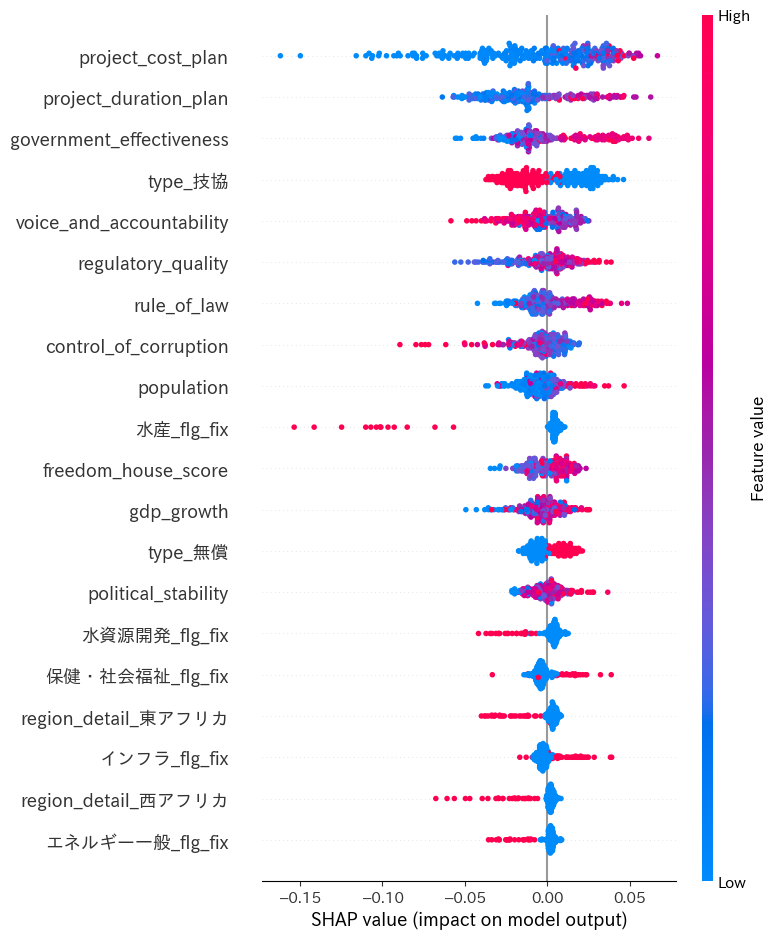

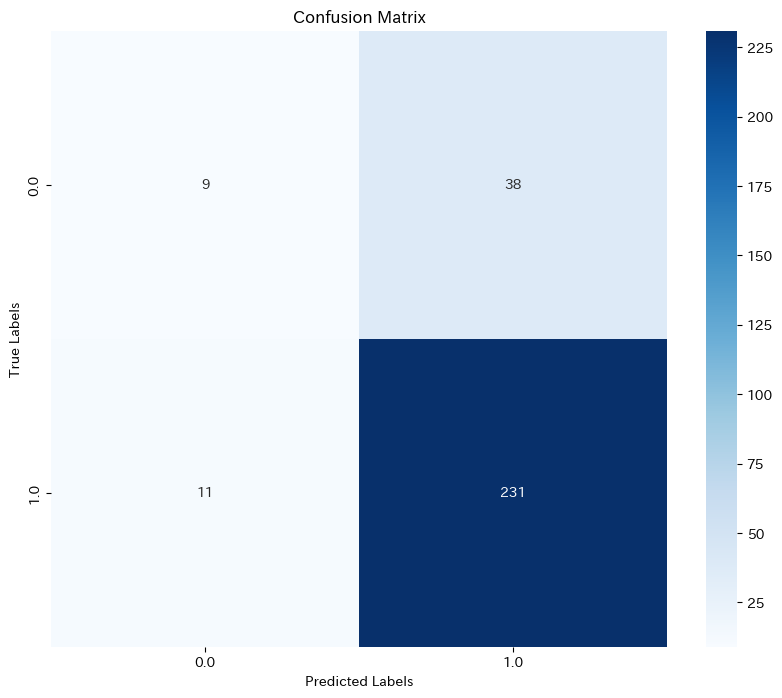

method, class, accuracy, precision, recall
proposed, all, 0.8304498269896193, 0.6543680297397769, 0.5730174081237911
proposed, 0.0, non, 0.45, 0.19148936170212766
proposed, 1.0, non, 0.8587360594795539, 0.9545454545454546
baseline, all, 0.727637360663785, 0.5, 0.5
baseline, 0.0, non, 0.16262975778546712, 0.16262975778546712
baseline, 1.0, non, 0.8373702422145328, 0.8373702422145328


In [37]:
reload(ml_numerical_classification_rf)
ml_numerical_classification_rf.train_and_evaluate_model(train_df=train_rf_df, valid_df=valid_rf_df)

cm.vis('results/classification/confusion_matrix_num_rf.csv','results/classification/result_num_rf.csv')


## XGBoost
- 数値系特徴量の追加

In [38]:
## train_test分割
train_df = df[df[YEAR_COL] <= (df[YEAR_COL].max() - TEST_LAST_N)][rf_feat + ['label']] 
valid_df = df[df[YEAR_COL] > (df[YEAR_COL].max() - TEST_LAST_N)][rf_feat + ['label']] 


[17:16:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



Accuracy: 0.7925170068027211
Precision: 0.6248410680228862
Recall: 0.6353260401412697
Macro F1: 0.6295470037801326
Balanced Accuracy: 0.6353260401412697
2


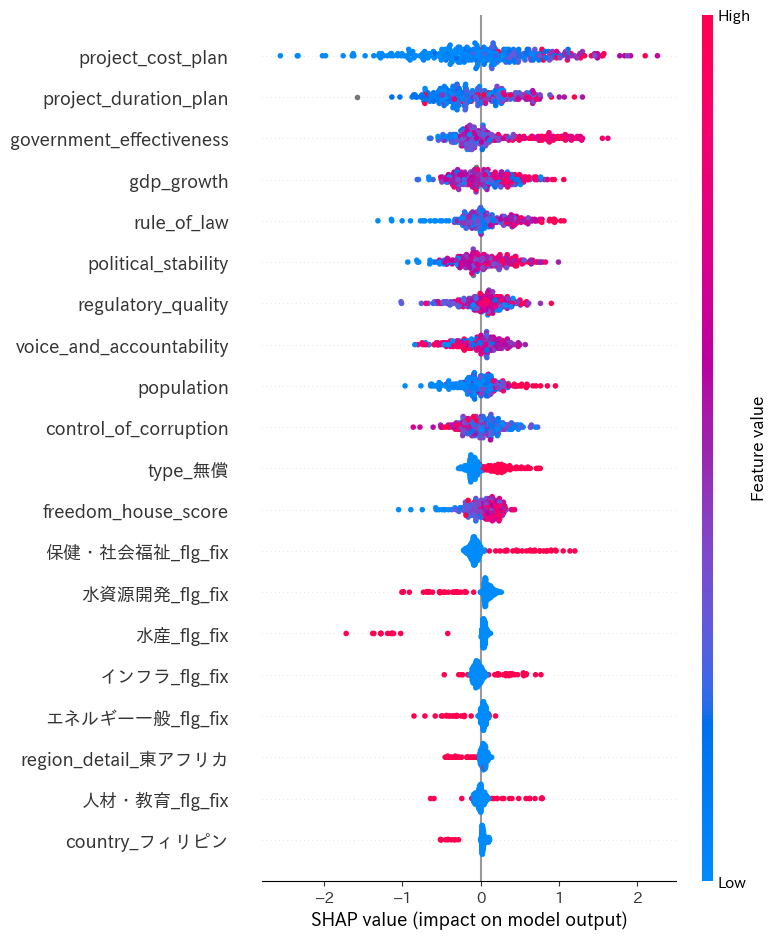

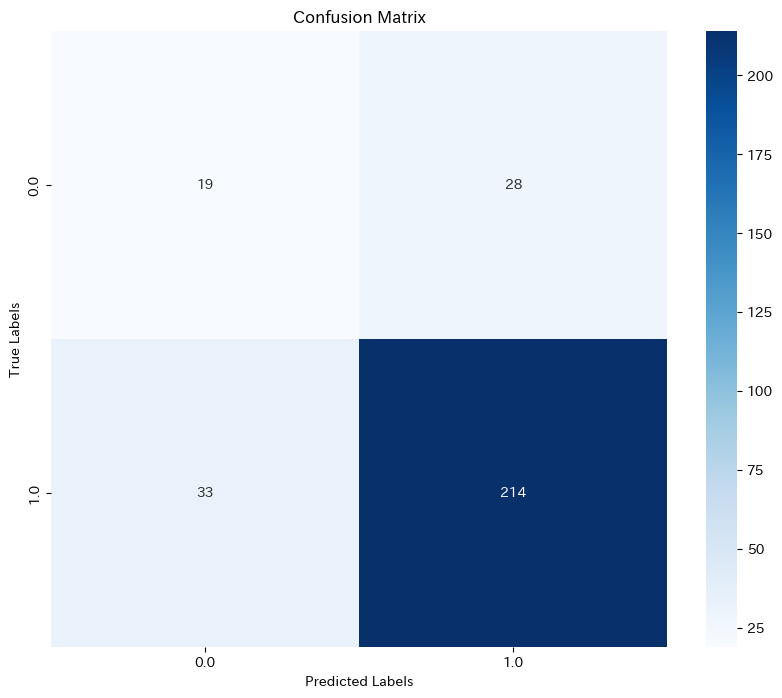

method, class, accuracy, precision, recall
proposed, all, 0.7925170068027211, 0.6248410680228862, 0.6353260401412697
proposed, 0.0, non, 0.36538461538461536, 0.40425531914893614
proposed, 1.0, non, 0.8842975206611571, 0.8663967611336032
baseline, all, 0.7313850710352169, 0.5, 0.5
baseline, 0.0, non, 0.1598639455782313, 0.1598639455782313
baseline, 1.0, non, 0.8401360544217688, 0.8401360544217688


In [39]:
reload(ml_numerical_classification_xgb)
ml_numerical_classification_xgb.train_and_evaluate_model(train_df=train_df, valid_df=valid_df)

cm.vis('results/classification/confusion_matrix_num_xgb.csv','results/classification/result_num_xgb.csv')


## lgbm
- 数値系特徴量の追加

In [40]:
## train_test分割
train_df = df[df[YEAR_COL] <= (df[YEAR_COL].max() - TEST_LAST_N)][features + ['label']] 
valid_df = df[df[YEAR_COL] > (df[YEAR_COL].max() - TEST_LAST_N)][features + ['label']] 


[LightGBM] [Info] Number of positive: 1122, number of negative: 384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6854
[LightGBM] [Info] Number of data points in the train set: 1506, number of used features: 250
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.745020 -> initscore=1.072226
[LightGBM] [Info] Start training from score 1.072226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


SHAP values array shape: (2, 294, 2923)


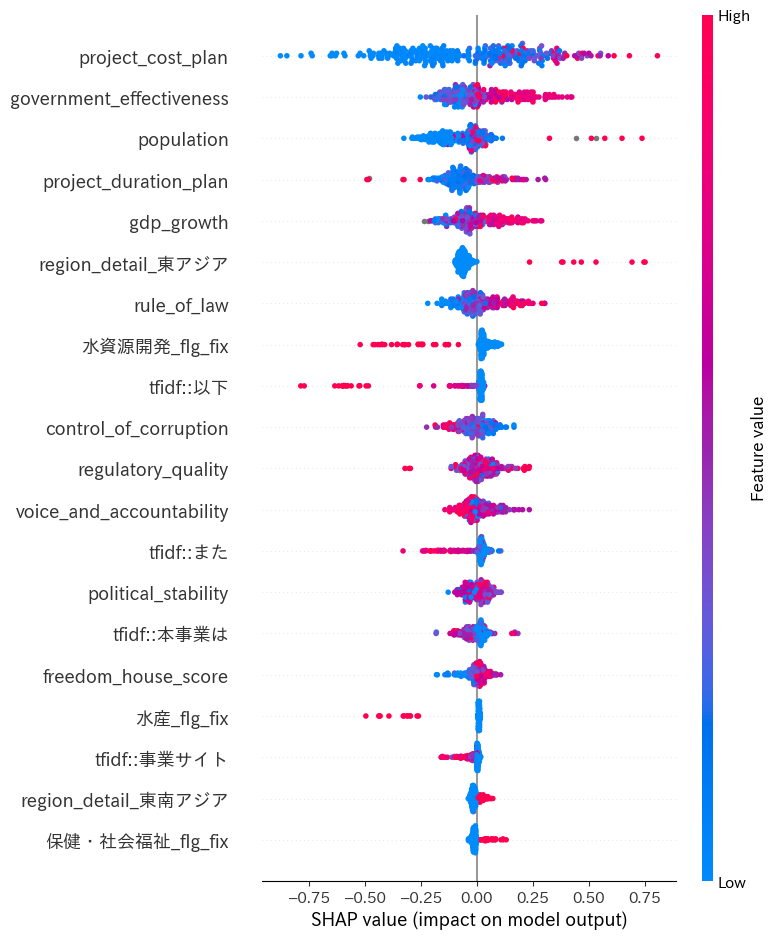

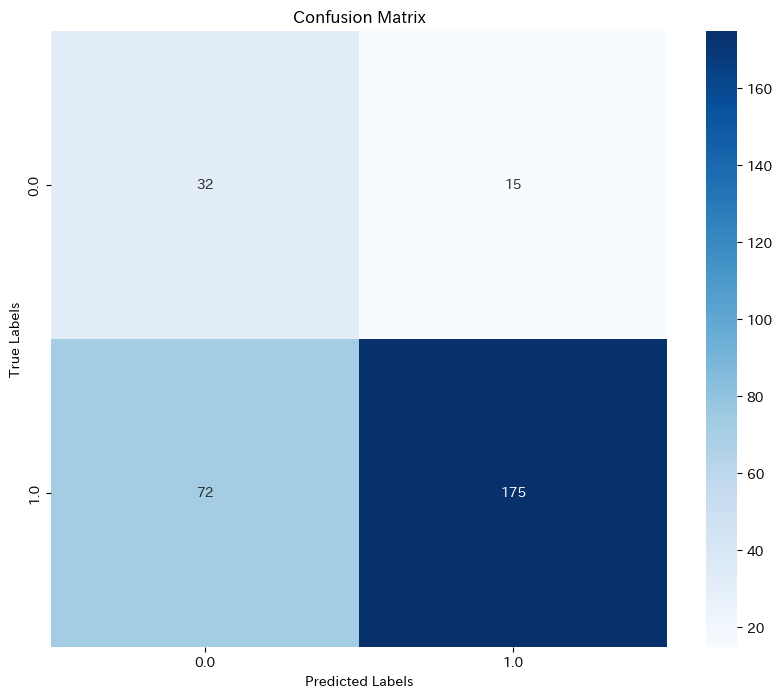

method, class, accuracy, precision, recall
proposed, all, 0.7040816326530612, 0.6143724696356275, 0.6946765440606426
proposed, 0.0, non, 0.3076923076923077, 0.6808510638297872
proposed, 1.0, non, 0.9210526315789473, 0.708502024291498
baseline, all, 0.7313850710352169, 0.5, 0.5
baseline, 0.0, non, 0.1598639455782313, 0.1598639455782313
baseline, 1.0, non, 0.8401360544217688, 0.8401360544217688


In [41]:
reload(ml_numerical_classification_lgb)
ml_numerical_classification_lgb.train_and_evaluate_model(train_df=train_df, valid_df=valid_df, n_splits=N_SPLITS, threshold_objective="macro_f1")

cm.vis('results/classification/confusion_matrix_num_lgb.csv','results/classification/result_num_lgb.csv')
